<a href="https://colab.research.google.com/github/steveazzolin/NLU-first-assignment/blob/main/code/NLU_first_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLU assignment 01
## Steve Azzolin

For further info about the functions implemented in this notebook please check the inline comments and TODO [this](TODO) report.

#### preparation

In [1]:
!git clone https://github.com/steveazzolin/nltk.git
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!mkdir ../data
!cp glove.6B.50d.txt ../data

Cloning into 'nltk'...
remote: Enumerating objects: 74853, done.
remote: Counting objects: 100% (703/703), done.
remote: Compressing objects: 100% (549/549), done.
remote: Total 74853 (delta 256), reused 303 (delta 153), pack-reused 74150
Receiving objects: 100% (74853/74853), 106.02 MiB | 22.29 MiB/s, done.
Resolving deltas: 100% (52410/52410), done.
--2021-04-20 16:17:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-20 16:17:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-20 16:17:42--  http

In [2]:
!pip uninstall nltk
!pip install spacy==2.2.4

Uninstalling nltk-3.2.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/nltk-3.2.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/nltk/*
Proceed (y/n)? y
  Successfully uninstalled nltk-3.2.5


#### import modules

In [3]:
import spacy
assert spacy.__version__ == '2.2.4'
from spacy import displacy

import matplotlib.pyplot as plt

import time
import sys
from tqdm import tqdm
from pathlib import Path

spacy_nlp = spacy.load('en_core_web_sm')
sys.path.insert(1, 'nltk/') #to import the local modified version of NLTK (for the extra point)

import nltk
from nltk.parse.transitionparser import TransitionParser, DependencyEvaluator
from nltk.corpus import dependency_treebank
nltk.download('dependency_treebank');

[nltk_data] Downloading package dependency_treebank to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping corpora/dependency_treebank.zip.


#### supporting functions

In [4]:
def plotDepGraph(spacy_doc):
  """
  function to plot the dependency graph inline
  """
  displacy.render(spacy_doc, style="dep", jupyter=True)

#### ex01

In [5]:
def es1(sentence:str, debug=False):
  """
  extract a path of dependency relations from the ROOT to a token
    - input is a sentence, you parse it and get a Doc object of spaCy
    - for each token the path will be a list of dependency relations, where first element is ROOT
  """
  spacy_doc = spacy_nlp(sentence)
  if debug: #plot the dependecy graph to inspect friendly the result
    plotDepGraph(spacy_doc)

  ret = []
  for sent in spacy_doc.sents:
      for token in sent:
        ret.append([t.dep_ for t in token.ancestors][::-1])
        ret[-1].extend([token.dep_])
  return ret


example = "I saw the man with a telescope."
es1(example)

[['ROOT', 'nsubj'],
 ['ROOT'],
 ['ROOT', 'dobj', 'det'],
 ['ROOT', 'dobj'],
 ['ROOT', 'dobj', 'prep'],
 ['ROOT', 'dobj', 'prep', 'pobj', 'det'],
 ['ROOT', 'dobj', 'prep', 'pobj'],
 ['ROOT', 'punct']]

#### ex02

In [6]:
def es2(sentence:str, debug=False):
  """
  extract subtree of a dependents given a token
    - input is a sentence, you parse it and get a Doc object of spaCy
    - for each token in Doc objects you extract a subtree of its dependents as a list (ordered w.r.t. sentence order)
  """
  spacy_doc = spacy_nlp(sentence)
  if debug: #plot the dependecy graph to inspect friendly the result
    plotDepGraph(spacy_doc)

  ret = []
  for sent in spacy_doc.sents:
      for token in sent:
        ret.append([t.text for t in token.subtree])
  return ret


example = "I saw the man with a telescope."
es2(example)

[['I'],
 ['I', 'saw', 'the', 'man', 'with', 'a', 'telescope', '.'],
 ['the'],
 ['the', 'man', 'with', 'a', 'telescope'],
 ['with', 'a', 'telescope'],
 ['a'],
 ['a', 'telescope'],
 ['.']]

#### ex03

In [7]:
def es3(sentence:str, subtree:list, debug=False):
  """
  check if a given list of tokens (segment of a sentence) forms a subtree
    - you parse a sentence and get a Doc object of spaCy
    - providing as an input ordered list of words from a sentence, you output True/False based on the sequence forming a subtree or not
  """
  assert " ".join(subtree) in sentence
  spacy_doc = spacy_nlp(sentence)
  if debug: #plot the dependecy graph to inspect friendly the result
    plotDepGraph(spacy_doc)

  for sent in spacy_doc.sents:
      for token in sent:
        desc = [t.text for t in token.subtree] #or one might reuse the function defined by es2()
        if desc == subtree:
          return True
  return False


example = "I saw the man with a telescope."
es3(example, ["the", "man", "with", "a", "telescope"]) , es3(example, ["man", "with", "a", "telescope"])

(True, False)

#### ex04

In [8]:
def es4(words:str, debug=False):
  """
  identify head of a span, given its tokens
    - input is a sequence of words (not necessarily a sentence)
    - output is the head of the span (single word)
  
  For consistency with other functions here the input is a Python string
  """
  spacy_doc = spacy_nlp(words)
  if debug: #plot the dependecy graph to inspect friendly the result
    plotDepGraph(spacy_doc)
  return list(spacy_doc.sents)[0].root


example = "I saw the man with a telescope."
es4(example)

saw

#### ex05

In [9]:
def es5(words:str, debug=False):
  """
  extract sentence subject, direct object and indirect object spans
    - input is a sentence, you parse it and get a Doc object of spaCy
    - output is lists of words that form a span (not a single word) for subject, direct object, and indirect object (if present of course, otherwise empty)
      - dict of lists, is better
  """
  spacy_doc = spacy_nlp(words)
  if debug: #plot the dependecy graph to inspect friendly the result
    plotDepGraph(spacy_doc)

  ret = {"nsubj":[], "dobj":[], "dative":[]}
  for sent in spacy_doc.sents:
      for token in sent:
        if token.dep_ in ["nsubj", "dobj", "dative"]:
          ret[token.dep_].append(" ".join([t.text for t in token.subtree]))
  return ret


example = "I saw the man with a telescope."
es5(example)
example2 = 'Gaia brought her cat Costina some delicious food'
es5(example2)

{'dative': ['Costina'],
 'dobj': ['her cat', 'some delicious food'],
 'nsubj': ['Gaia']}

#### extra point


LAS=0.76 USA=0.76 without GLOVE

Reading GLOVE....
GLOVE read

LAS=0.09 USA=0.09 with GLOVE



  0%|          | 0/15 [00:00<?, ?it/s]


LAS=0.88 USA=0.88 with children features



100%|██████████| 15/15 [24:09<00:00, 96.64s/it] 


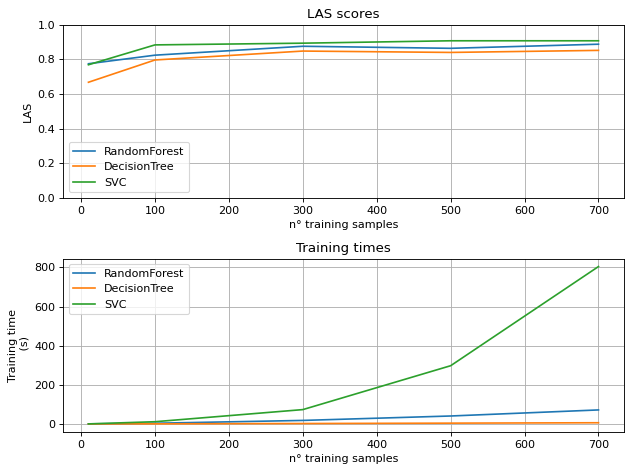

CPU times: user 25min 12s, sys: 7.19 s, total: 25min 20s
Wall time: 25min 20s


In [10]:
%%time

def extra_point():
  tp = TransitionParser('arc-standard', use_glove=False, use_children=False, model=2)
  tp.train(dependency_treebank.parsed_sents()[:100], 'tp.model')
  parses = tp.parse(dependency_treebank.parsed_sents()[-20:], 'tp.model')
  de = DependencyEvaluator(parses, dependency_treebank.parsed_sents()[-20:])
  las, uas = de.eval()
  print("\nLAS={} USA={} without GLOVE\n".format(round(las,2), round(uas,2)))

  tp = TransitionParser('arc-standard', use_glove=True, use_children=False, model=2)
  tp.train(dependency_treebank.parsed_sents()[:100], 'tp.model')
  parses = tp.parse(dependency_treebank.parsed_sents()[-20:], 'tp.model')
  de = DependencyEvaluator(parses, dependency_treebank.parsed_sents()[-20:])
  las, uas = de.eval()
  print("\nLAS={} USA={} with GLOVE\n".format(round(las,2), round(uas,2)))

  tp = TransitionParser('arc-standard', use_glove=False, use_children=True, model=2)
  tp.train(dependency_treebank.parsed_sents()[:100], 'tp.model')
  parses = tp.parse(dependency_treebank.parsed_sents()[-20:], 'tp.model')
  de = DependencyEvaluator(parses, dependency_treebank.parsed_sents()[-20:])
  las, uas = de.eval()
  print("\nLAS={} USA={} with children features\n".format(round(las,2), round(uas,2)))


  results = []
  times = []
  train_data_to_test = [10, 100, 300, 500, 700]
  pbar = tqdm(total=len(train_data_to_test*3))
  for i , model in enumerate([0, 1, 2]):
    results.append([])
    times.append([])
    for train_data in train_data_to_test:    
      start = time.time()
      tp = TransitionParser('arc-standard', use_glove=False, use_children=True, model=model)
      tp.train(dependency_treebank.parsed_sents()[:train_data], 'tp.model')

      times[i].append(time.time()-start)

      parses = tp.parse(dependency_treebank.parsed_sents()[-20:], 'tp.model')
      de = DependencyEvaluator(parses, dependency_treebank.parsed_sents()[-20:])
      las, _ = de.eval()
      results[i].append(las)
      pbar.update(1)      
  pbar.close()

  
  plt.figure(figsize=(8, 6), dpi=80)

  ax1 = plt.subplot(211)
  ax1.plot(train_data_to_test, results[0], label="RandomForest")
  ax1.plot(train_data_to_test, results[1], label="DecisionTree")
  ax1.plot(train_data_to_test, results[2], label="SVC")
  ax1.set(xlabel='n° training samples', ylabel='LAS', title='LAS scores')
  ax1.set_ylim(0.0, 1.0)
  plt.legend()
  plt.grid()

  ax2 = plt.subplot(212, sharex=ax1)
  ax2.plot(train_data_to_test, times[0], label="RandomForest")
  ax2.plot(train_data_to_test, times[1], label="DecisionTree")
  ax2.plot(train_data_to_test, times[2], label="SVC")
  ax2.set(xlabel='n° training samples', ylabel='Training time\n (s)', title='Training times')

  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.show()



extra_point()